In [110]:
# PART 0: Downloading the Data

import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
import scikit_posthocs as sp 

from scipy.stats import levene, kruskal

# I put the data in a folder named data/
# The data is too large to upload to github, so this is only local. 
path_0 = "data/exported_new_results_nih_funded_gene_annotations_clean-000000000000.csv"
path_1 = "data/exported_new_results_nih_funded_gene_annotations_clean-000000000001.csv"

raw_data_0 = pd.read_csv(path_0)
raw_data_1 = pd.read_csv(path_1)


In [3]:
# Just looking at the parts of the data
print(raw_data_0.columns)
print(raw_data_0.shape)
print(raw_data_1.columns)
print(raw_data_1.shape)

Index(['DB_Object_Symbol', 'DB_Object_Name', 'DB_Object_ID', 'DB_Object_Type',
       'DB_Object_Synonym', 'GO_ID', 'Aspect', 'Qualifier', 'Evidence_Code',
       'pmid_extracted', 'PMID', 'DB_Reference', 'PROJECT_NUMBER',
       'APPLICATION_ID', 'PROJECT_TITLE', 'PI_NAMEs', 'ORG_NAME', 'ORG_STATE',
       'ORG_COUNTRY', 'TOTAL_COST', 'DIRECT_COST_AMT', 'INDIRECT_COST_AMT',
       'FY', 'PROJECT_START', 'PROJECT_END', 'ACTIVITY', 'FULL_PROJECT_NUM',
       'PROJECT_TERMS', 'PHR', 'annotation_date', 'Assigned_By', 'Taxon'],
      dtype='object')
(197441, 32)
Index(['DB_Object_Symbol', 'DB_Object_Name', 'DB_Object_ID', 'DB_Object_Type',
       'DB_Object_Synonym', 'GO_ID', 'Aspect', 'Qualifier', 'Evidence_Code',
       'pmid_extracted', 'PMID', 'DB_Reference', 'PROJECT_NUMBER',
       'APPLICATION_ID', 'PROJECT_TITLE', 'PI_NAMEs', 'ORG_NAME', 'ORG_STATE',
       'ORG_COUNTRY', 'TOTAL_COST', 'DIRECT_COST_AMT', 'INDIRECT_COST_AMT',
       'FY', 'PROJECT_START', 'PROJECT_END', 'ACTIVITY', 

In [4]:
# PART 1: Pre-Processing the Data

# Concatenate the two datafiles together, check that it worked. 
data = pd.concat((raw_data_0, raw_data_1), ignore_index=True)
data.shape

(395002, 32)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395002 entries, 0 to 395001
Data columns (total 32 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   DB_Object_Symbol   395002 non-null  object 
 1   DB_Object_Name     395002 non-null  object 
 2   DB_Object_ID       395002 non-null  object 
 3   DB_Object_Type     395002 non-null  object 
 4   DB_Object_Synonym  394840 non-null  object 
 5   GO_ID              395002 non-null  object 
 6   Aspect             395002 non-null  object 
 7   Qualifier          395002 non-null  object 
 8   Evidence_Code      395002 non-null  object 
 9   pmid_extracted     395002 non-null  int64  
 10  PMID               395002 non-null  int64  
 11  DB_Reference       395002 non-null  object 
 12  PROJECT_NUMBER     395002 non-null  object 
 13  APPLICATION_ID     395002 non-null  int64  
 14  PROJECT_TITLE      395002 non-null  object 
 15  PI_NAMEs           395002 non-null  object 
 16  OR

In [6]:
print(data['ORG_STATE'].unique())
print(data['ORG_COUNTRY'].unique())

['NE' 'MA' 'KS' 'HI' 'BC' 'OH' 'MD' 'WA' 'WI' 'NY' 'PA' 'TX' 'GA' 'SC'
 'NC' 'DC' 'NJ' 'FL' 'TN' 'MO' 'CA' 'IA' 'VT' 'CT' 'MN' 'IL' 'RI' 'AR'
 'VA' 'MI' 'OR' 'AZ' 'CO' 'AL' 'KY' 'OK' 'MT' 'ME' 'IN' 'ND' nan 'NV' 'LA'
 'NH' 'UT' 'MS' 'NM' 'WV' 'WY' 'ON' 'PQ' 'DE' 'QC' 'SD']
['UNITED STATES' 'CANADA' 'COLOMBIA' 'UNITED KINGDOM' 'BELGIUM' 'ISRAEL'
 'SPAIN' 'AUSTRALIA' 'CHINA' 'BRAZIL']


In [7]:
# confirming  that nan is state is associated with non-US countries (does not need to be handled) 
data[data['ORG_STATE'].isna()]["ORG_COUNTRY"].unique()

array(['COLOMBIA', 'UNITED KINGDOM', 'BELGIUM', 'ISRAEL', 'SPAIN',
       'AUSTRALIA', 'CHINA', 'BRAZIL'], dtype=object)

In [8]:
# checking for other null values (want to look specifically at model organisms (RQ1) and proteins(RQ2))
data[data['PMID'].isna()]
data[data['Taxon'].isna()] # organism group

data[data["PMID"].isna()] # gene symbol, uniprot id 
data[data["pmid_extracted"].isna()] # gene symbol, uniprot id 

,DB_Object_Symbol,DB_Object_Name,DB_Object_ID,DB_Object_Type,DB_Object_Synonym,GO_ID,Aspect,Qualifier,Evidence_Code,pmid_extracted,...,FY,PROJECT_START,PROJECT_END,ACTIVITY,FULL_PROJECT_NUM,PROJECT_TERMS,PHR,annotation_date,Assigned_By,Taxon


In [9]:
data['DB_Object_Type'].unique()

array(['protein'], dtype=object)

In [10]:
data.head()

,DB_Object_Symbol,DB_Object_Name,DB_Object_ID,DB_Object_Type,DB_Object_Synonym,GO_ID,Aspect,Qualifier,Evidence_Code,pmid_extracted,...,FY,PROJECT_START,PROJECT_END,ACTIVITY,FULL_PROJECT_NUM,PROJECT_TERMS,PHR,annotation_date,Assigned_By,Taxon
0,Pink1,"Serine/threonine-protein kinase PINK1, mitocho...",B5DFG1,protein,Pink1,GO:0031999,P,involved_in,HMP,25421206,...,2014,2005-02-10,2016-03-31,R01,5R01MH073490-11,Address;AIDS neuropathy;Autophagocytosis;Brain...,While treatment for HIV infection has improve...,20210212,RGD,taxon:10116
1,Pink1,"Serine/threonine-protein kinase PINK1, mitocho...",B5DFG1,protein,Pink1,GO:0000266,P,involved_in,HMP,25421206,...,2014,2005-02-10,2016-03-31,R01,5R01MH073490-11,Address;AIDS neuropathy;Autophagocytosis;Brain...,While treatment for HIV infection has improve...,20210212,RGD,taxon:10116
2,Nf1,"Neurofibromin 1, isoform B",Q9VBJ2,protein,Nf1|Dmel\CG8318|FBpp0084326|NF-1|NF1|Nf-1|dNF1...,GO:0008344,P,involved_in,IMP,25962619,...,2016,2008-09-01,2020-07-31,R01,2R01GM084947-09,Address;base;Cells;Clustered Regularly Intersp...,PROJECT NARRATIVE This project is seeking cont...,20160811,FlyBase,taxon:7227
3,Cirl,Latrophilin Cirl,A1Z7G7,protein,Cirl|CG8639,GO:0008344,P,involved_in,IMP,25962619,...,2013,2008-09-01,2016-07-31,R01,5R01GM084947-06,NaN,This project is seeking continued support...,20160811,FlyBase,taxon:7227
4,DAT,Sodium-dependent dopamine transporter,Q7K4Y6,protein,DAT|fmn|CG8380,GO:0008344,P,involved_in,IMP,25962619,...,2014,2008-09-01,2016-07-31,R01,5R01GM084947-07,Address;base;Biological;Biological Assay;Biolo...,This project is seeking continued support...,20160811,FlyBase,taxon:7227


<Axes: >

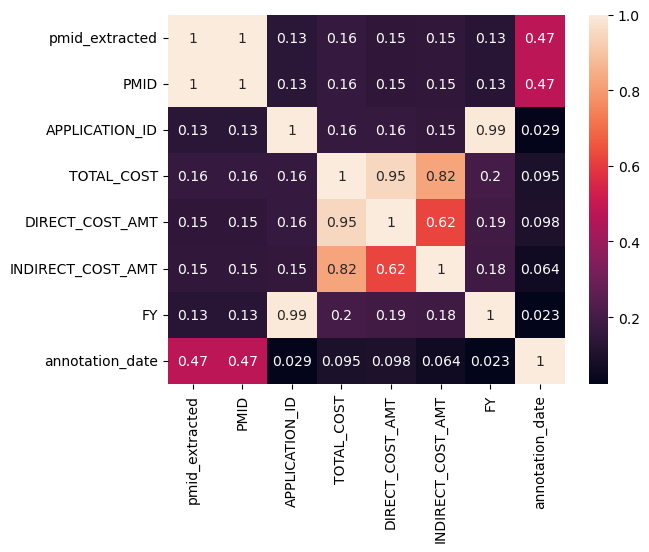

In [11]:
# -- PART 2: High Level Overview 

# correlation map on quantitative variables (general)
corr_matrix = data.select_dtypes(include=[np.number]).corr()
plt.figure()
sns.heatmap(corr_matrix, annot=True)

In [12]:
# correlation map on categorical variables 

In [49]:
# -- PART 3: General Functions 
def add_rank_cols(df, cost_col, num_proj_col): 
    df['total_cost_rank'] = df[cost_col].rank(method = 'min', ascending=False).astype(int)
    df['count_rank'] = df[num_proj_col].rank(method = 'min', ascending=False).astype(int)

    return df 

# given data from 2013 to 2022, rank column to see how the taxon ranks over time  
def add_rank_by_year(df, year, new_col_name):
    df[new_col_name] = df[year].rank(method = 'min', ascending=False).astype(int)
    return df 

# get top x data points for a specific column in a df (asc = if True, return in ascending order, o/w descending)
def get_top_x(df, col, num, asc): 
    mod_df = df.sort_values(col, ascending = True).head(num).reset_index()
    mod_df = mod_df.sort_values(col, ascending = asc)

    return mod_df 

# given the aggregated data column (prior to taking only top) and then the top 10, 
# create a column Other that has the cost_col of all the non-top 10 
def format_for_pie(agg_df, top_df, cost_col, var_col): 
    count = top_df[cost_col].to_list()
    labels = top_df[var_col].to_list()

    # get other column, then add to count and labels list 
    other = agg_df[cost_col].sum() - top_df[cost_col].sum()
    count.append(other)
    labels.append('Other')

    return count, labels 


In [14]:
# -- PART 4: RQ1 - How much NIH money is spent on different model organisms? Is there a bias?

# x = model organism = Taxon, y = TOTAL_COST 

# Task 1: Evaluate overall NIH money across all time (do year after)

# group data by total cost per taxon across all time 
df_cost_taxon = data[['Taxon', 'TOTAL_COST']]
tot_cost_per_taxon = df_cost_taxon.groupby('Taxon').agg(
    num_projects = ('Taxon', 'size'), 
    total_cost = ('TOTAL_COST', 'sum')
).sort_values(by = ['total_cost', 'num_projects'], ascending=[False, False])

# add ranking columns for how they rank against other taxons 
tot_cost_per_taxon = add_rank_cols(tot_cost_per_taxon, 'total_cost', 'num_projects')

tot_cost_per_taxon.head()

,num_projects,total_cost,total_cost_rank,count_rank
Taxon,,,,
taxon:9606,213433,9.084689e+10,1,1
taxon:10090,74620,3.108294e+10,2,2
taxon:7227,21845,8.732740e+09,3,3
taxon:559292,20264,7.177757e+09,4,4
taxon:7955,13621,5.507444e+09,5,5


<BarContainer object of 10 artists>

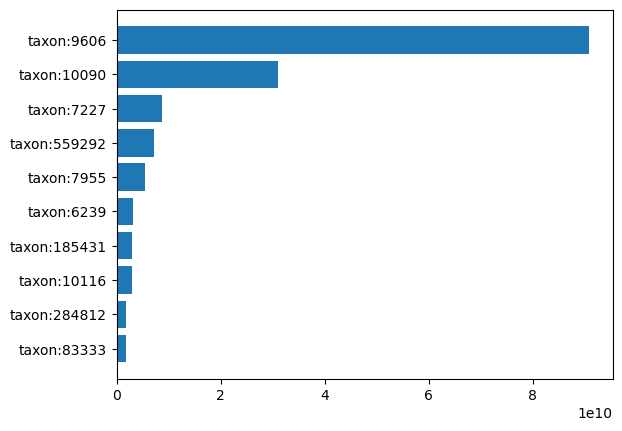

In [15]:
# get top 10 taxons with the highest total cost 
t10_taxon_cost = get_top_x(tot_cost_per_taxon, 'total_cost_rank', 10, False)

# visualize as a bar plot 
plt.barh(t10_taxon_cost['Taxon'], t10_taxon_cost['total_cost'])


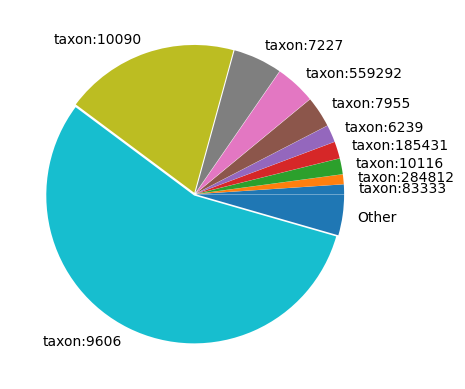

In [16]:
# visualize as a pie chart, comparing against ALL others 
t10_taxon_pie = format_for_pie(tot_cost_per_taxon, t10_taxon_cost, 'total_cost', 'Taxon')
plt_explode = [0.01]*11 #[0,0,0,0,0,0,0,0,0,0,0]
plt.pie(t10_taxon_pie[0], labels = t10_taxon_pie[1], explode = plt_explode)
plt.show()

<BarContainer object of 10 artists>

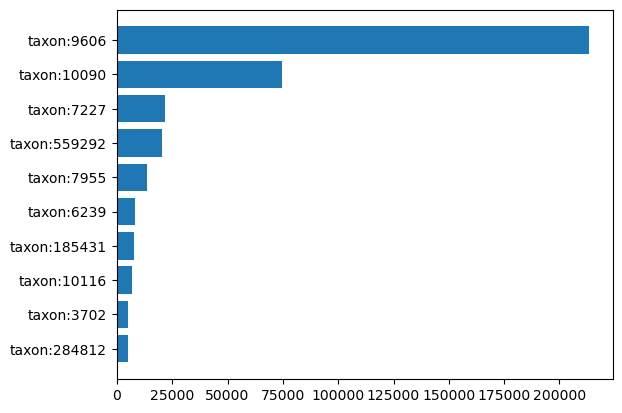

In [33]:
# get top 10 taxons with the highest number of projects
t10_taxon_proj = get_top_x(tot_cost_per_taxon, 'count_rank', 10, False)

# visualize as a bar plot 
plt.barh(t10_taxon_proj['Taxon'], t10_taxon_proj['num_projects'])

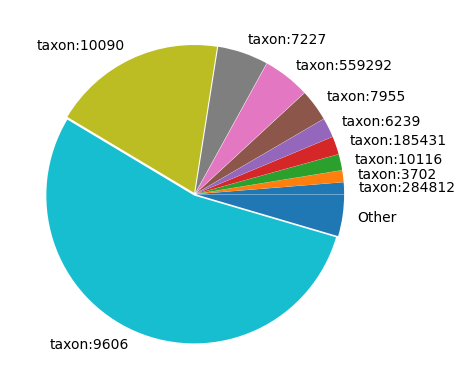

In [34]:
# visualize as a pie chart, comparing against ALL others 
t10_taxon_pie = format_for_pie(tot_cost_per_taxon, t10_taxon_proj, 'num_projects', 'Taxon')
plt_explode = [0.01]*11 #[0,0,0,0,0,0,0,0,0,0,0]
plt.pie(t10_taxon_pie[0], labels = t10_taxon_pie[1], explode = plt_explode)
plt.show()

In [61]:
# Task 2: Now that we know the overall max, we want to see if these rankings are consistent over time 

# create dataframes that look at the total cost and the number of projects over time
df_rank_time = data[['Taxon', 'TOTAL_COST', 'FY']]

taxon_rank_cost_by_year = df_rank_time.groupby(['Taxon', 'FY']).agg(
    num_projects = ('Taxon', 'size'), 
    total_cost = ('TOTAL_COST', 'sum')
).reset_index().pivot(index='Taxon', columns = 'FY', values = 'total_cost').astype('Int64')

taxon_rank_proj_by_year = df_rank_time.groupby(['Taxon', 'FY']).agg(
    num_projects = ('Taxon', 'size'), 
    total_cost = ('TOTAL_COST', 'sum')
).reset_index().pivot(index='Taxon', columns = 'FY', values = 'num_projects').astype('Int64')


# add ranking columns for how they rank against other taxons (cost)
taxon_rank_cost_by_year = add_rank_by_year(taxon_rank_cost_by_year, 2016, '2016_rank')
taxon_rank_cost_by_year = add_rank_by_year(taxon_rank_cost_by_year, 2017, '2017_rank')
taxon_rank_cost_by_year = add_rank_by_year(taxon_rank_cost_by_year, 2018, '2018_rank')
taxon_rank_cost_by_year = add_rank_by_year(taxon_rank_cost_by_year, 2019, '2019_rank')
taxon_rank_cost_by_year = add_rank_by_year(taxon_rank_cost_by_year, 2020, '2020_rank')
taxon_rank_cost_by_year = add_rank_by_year(taxon_rank_cost_by_year, 2021, '2021_rank')
taxon_rank_cost_by_year = add_rank_by_year(taxon_rank_cost_by_year, 2022, '2022_rank')

# add ranking columns for how they rank against other taxons (num_projects)
taxon_rank_proj_by_year = add_rank_by_year(taxon_rank_proj_by_year, 2016, '2016_rank')
taxon_rank_proj_by_year = add_rank_by_year(taxon_rank_proj_by_year, 2017, '2017_rank')
taxon_rank_proj_by_year = add_rank_by_year(taxon_rank_proj_by_year, 2018, '2018_rank')
taxon_rank_proj_by_year = add_rank_by_year(taxon_rank_proj_by_year, 2019, '2019_rank')
taxon_rank_proj_by_year = add_rank_by_year(taxon_rank_proj_by_year, 2020, '2020_rank')
taxon_rank_proj_by_year = add_rank_by_year(taxon_rank_proj_by_year, 2021, '2021_rank')
taxon_rank_proj_by_year = add_rank_by_year(taxon_rank_proj_by_year, 2022, '2022_rank')

#tot_cost_per_taxon.head()
taxon_rank_proj_by_year.head(20)

FY,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2016_rank,2017_rank,2018_rank,2019_rank,2020_rank,2021_rank,2022_rank
Taxon,,,,,,,,,,,,,,,,,
taxon:10036,2,2,2,2,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,96,114,107,99,85,68,60
taxon:10090,6938,8007,9353,9812,9712,9072,7416,5929,4640,3741,2,2,2,2,2,2,2
taxon:10090|taxon:64320,<NA>,<NA>,<NA>,<NA>,<NA>,1,1,1,1,2,116,114,107,99,85,68,49
taxon:10116,868,936,971,868,866,752,590,478,312,259,8,8,8,8,8,10,10
taxon:10254,12,20,13,13,15,19,14,22,19,5,32,29,26,30,23,24,34
taxon:10299,11,15,14,17,21,16,17,17,6,1,24,24,28,27,28,36,60
taxon:10315,2,2,2,2,2,<NA>,2,2,2,2,96,91,107,77,69,56,49
taxon:10377,3,3,3,3,3,<NA>,<NA>,<NA>,<NA>,<NA>,79,76,107,99,85,68,60
taxon:10665,1,1,1,1,1,1,1,<NA>,<NA>,<NA>,116,114,107,99,85,68,60


In [65]:
# look at the top 5 taxons and drop all columns unrelated to rank
t5_taxon = ['taxon:9606', 'taxon:10090', 'taxon:7227', 'taxon:559292', 'taxon:7955']
taxon_rank_cost_by_year[
    taxon_rank_cost_by_year.index.isin(t5_taxon)
].sort_values('2016_rank', ascending=True).reset_index()[
    ['Taxon', '2016_rank', '2017_rank', '2018_rank', '2019_rank', '2020_rank', '2021_rank', '2022_rank']
]

FY,Taxon,2016_rank,2017_rank,2018_rank,2019_rank,2020_rank,2021_rank,2022_rank
0,taxon:9606,1,1,1,1,1,1,1
1,taxon:10090,2,2,2,2,2,2,2
2,taxon:7227,3,3,3,3,3,4,3
3,taxon:559292,4,4,4,4,4,3,4
4,taxon:7955,5,5,5,5,5,5,6


In [ ]:
# Task 3: Given that human is clearly the most heavily funnded and has the most 
# number of projects, lets take a look at how funding and number of projects has 
# varied over time 

# 1 = taxon:9606 (human), 2 = taxon:10090 (house mouse), 3 = taxon:7227 (fruit fly), 
# 4 = taxon:559292 (brewer's yeast), 5 = taxon:7955 (zebrafish)
#df_rank_time = data[['Taxon', 'TOTAL_COST', 'FY']]

# filter for only human taxons 
taxon_human = data[data['Taxon'] == 'taxon:9606'][['TOTAL_COST', 'FY']]

# get total cost and number of projects per year 
taxon_human_cost = taxon_human.groupby('FY').agg(
    num_projects = ('FY', 'size'), 
    total_cost = ('FY', 'sum')
).reset_index()

taxon_human_cost.head()

,FY,num_projects,total_cost
0,2013,19573,39400449
1,2014,26257,52881598
2,2015,29537,59517055
3,2016,29464,59399424
4,2017,25785,52008345


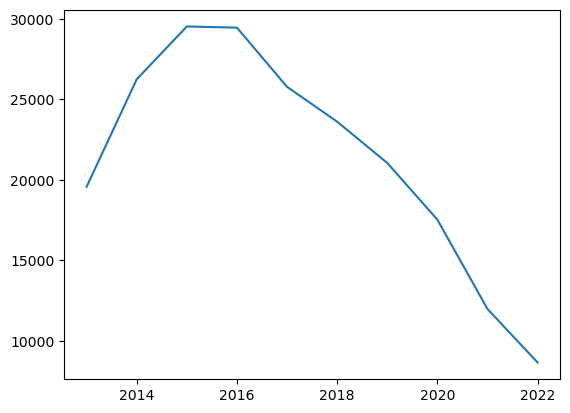

In [85]:
# plot a line graph showing how total cost and num projects have varied over time
plt.plot(taxon_human_cost['FY'], taxon_human_cost['num_projects'], label = 'Number of Projects')
plt.show()

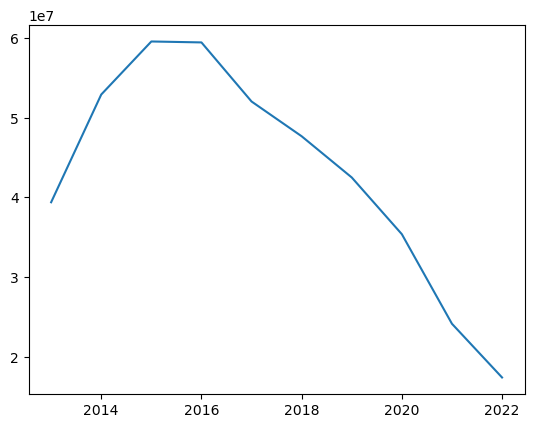

In [86]:
plt.plot(taxon_human_cost['FY'], taxon_human_cost['total_cost'], label = 'Total Cost of Projects')
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


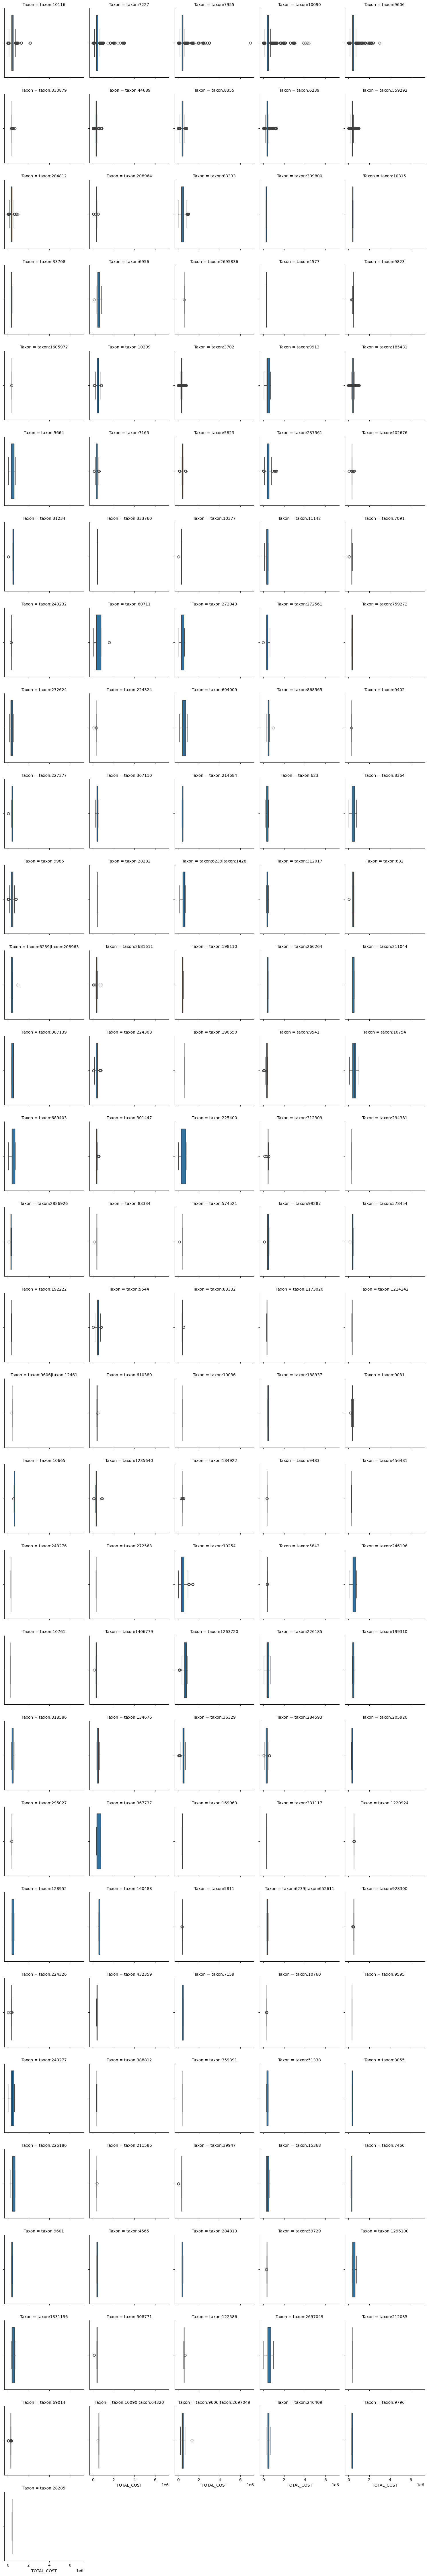

In [94]:
# Task 4: Run a statistical test to see if there is any bias in the NIH funding for different 
# model organisms (spoiler alert: answer is yes)

# Kruskal-Wallis: checks for stat. significant differences between them 
# assumptions: ordinal (yes), independent samples (yes), 
# distributions of the groups must have the same shape (uncertain)

rq1_stat_df = data[['Taxon', 'TOTAL_COST']]

rq1_stat = df_cost_taxon.groupby('Taxon').agg(
    total_cost = ('TOTAL_COST', 'sum')
).sort_values(by = 'total_cost', ascending = False).reset_index()

# create boxplot to check same shape 
boxplot = sns.FacetGrid(rq1_stat_df, col = 'Taxon', col_wrap = 5, sharey = False)
boxplot.map(sns.boxplot, 'TOTAL_COST')

In [ ]:
# boxplot is difficult to visualize so switching to checking if distribution has similar 
# variance via Levene (conclusion: statistically significant, assumption is violated)
list_of_taxons = rq1_stat_df['Taxon'].unique()

data_by_taxon = []
for taxon in list_of_taxons: 
    data_points = rq1_stat_df[rq1_stat_df['Taxon'] == taxon]['TOTAL_COST'].values

    # avoids nan issue with fewer than 2 data points
    if len(data_points) > 5 and np.std(data_points) > 0: 
        data_by_taxon.append(data_points)

f, p = levene(*data_by_taxon)
print(f, p)

34.52945870445597 0.0


In [ ]:
# Run Kruskal-Wallis test (high significance value, indicating a bias)
H, p = kruskal(*data_by_taxon)
print(H, p)

23354.72138987827 0.0


<Axes: >

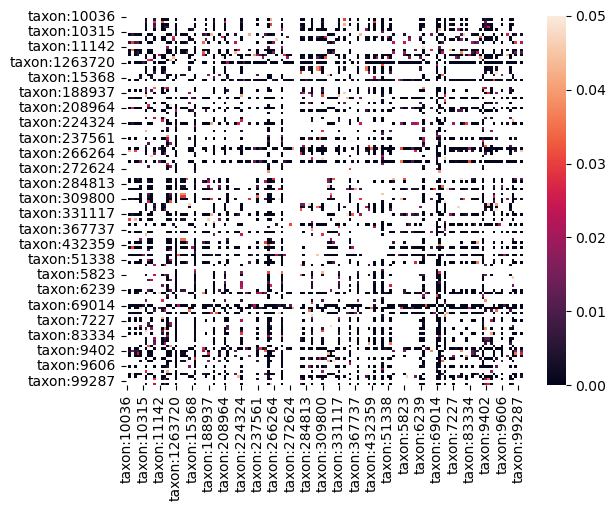

In [ ]:
# Run Dunn Test (post-hoc)

# remove N/A values from df
dunn_df = rq1_stat_df[['Taxon', 'TOTAL_COST']].dropna()
p_values = sp.posthoc_dunn(
    dunn_df, 
    group_col = 'Taxon',
    val_col = 'TOTAL_COST', 
    p_adjust='holm'
)


# use correlation matrix to visualize statistical significance (only looking at p<0.5)
plt.figure()
sns.heatmap(
    p_values.where(p_values <= 0.05),
    vmin = 0, 
    vmax = 0.05
)

# values are filtered for statistical significance, can see several extremely dark values
# specifically black, indicating high presence of bias in NIH funding based on taxon 

In [19]:
# -- PART 5: RQ2 - How much NIH money is spent on different proteins? Is there a bias?

# protein = DB_Object_ID  

In [20]:
# -- PART 5: RQ3 - How much NIH money is spent on different functions? Is there a bias?

# function = GO_ID 

# filter dataset to focus on RQ1 (go_id = model organism/function, total_cost = cost)
model_org_rq = data[['GO_ID', 'TOTAL_COST']]
model_org_rq.head()


,GO_ID,TOTAL_COST
0,GO:0031999,349161.0
1,GO:0000266,349161.0
2,GO:0008344,808286.0
3,GO:0008344,775374.0
4,GO:0008344,791836.0


In [21]:
# looking for top 20 go_id by cost (include number of occurrences)
model_org_df = model_org_rq.groupby('GO_ID').agg(
    count = ('GO_ID', 'size'),     
    sum_total_cost = ('TOTAL_COST', 'sum')
)

# sort primarily on total cost and then secondarily on cost 
model_org_df = model_org_df.sort_values(
    by = ['sum_total_cost', 'count'],
    ascending=[False, False]
)

# add rankings (sorted by highest total funding and highest number of approved projects)
model_org_df['total_cost_rank'] = model_org_df['sum_total_cost'].rank(method = 'min', ascending=False).astype(int)
model_org_df['count_rank'] = model_org_df['count'].rank(method = 'min', ascending=False).astype(int)

model_org_df

,count,sum_total_cost,total_cost_rank,count_rank
GO_ID,,,,
GO:0005515,144180,6.299437e+10,1,1
GO:0042802,6991,3.001964e+09,2,2
GO:0005634,4939,1.936890e+09,3,4
GO:0008270,5319,1.663527e+09,4,3
GO:0005737,3467,1.387642e+09,5,5
...,...,...,...,...
GO:0089720,1,2.659220e+05,5235,5205
GO:1900118,1,2.659220e+05,5235,5205
GO:0006006,1,2.482730e+05,5237,5205


In [22]:
# create dataframe of the top 10 by count and sum_total_cost  
t10_sum_tot_count = model_org_df.sort_values('total_cost_rank', ascending=True).head(10).reset_index()
t10_count = model_org_df.sort_values('count', ascending=False).head(10).reset_index()

#t10_sum_tot_count
t10_count

,GO_ID,count,sum_total_cost,total_cost_rank,count_rank
0,GO:0005515,144180,6.299437e+10,1,1
1,GO:0042802,6991,3.001964e+09,2,2
2,GO:0008270,5319,1.663527e+09,4,3
3,GO:0005634,4939,1.936890e+09,3,4
4,GO:0005737,3467,1.387642e+09,5,5
5,GO:0005886,3210,1.289698e+09,6,6
6,GO:0098978,2758,1.217563e+09,7,7
7,GO:0036064,2104,8.547373e+08,9,8
8,GO:0150104,1724,1.064575e+09,8,9
9,GO:0006913,1512,5.870347e+08,11,10


<BarContainer object of 10 artists>

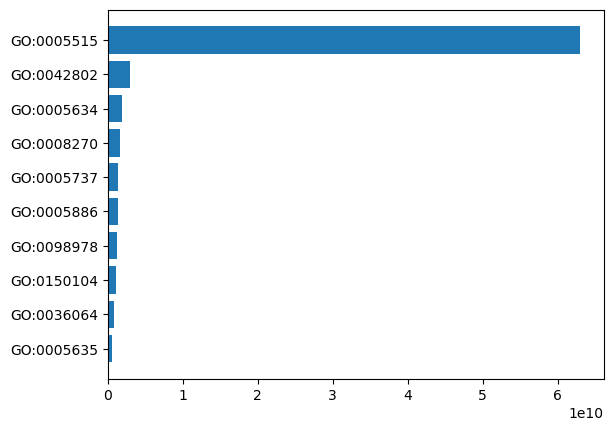

In [23]:
# save in descending order to have a better graph order 
t10_sum_tot_count = t10_sum_tot_count.sort_values('total_cost_rank', ascending=False)

# create a barplot showing the model organism/function against the total cost 
plt.barh(t10_sum_tot_count['GO_ID'], t10_sum_tot_count['sum_total_cost'])

<BarContainer object of 10 artists>

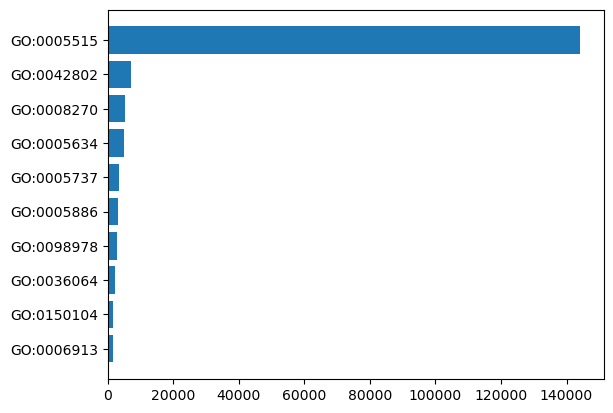

In [24]:
# save in descending order to have a better graph order 
t10_count = t10_count.sort_values('count', ascending=True)

# create a barplot showing the model organism/function against the total cost 
plt.barh(t10_count['GO_ID'], t10_count['count'])

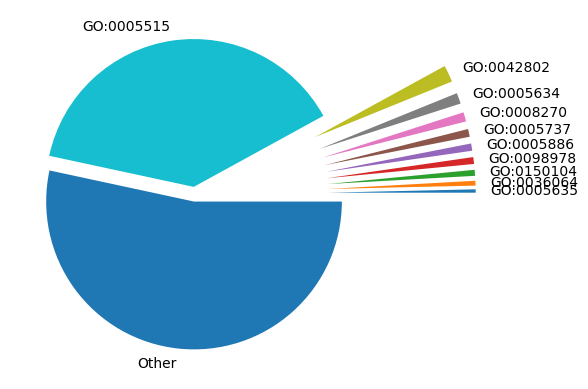

In [25]:
# set up data source for sum_total_count pie chart (want ratio of top 10 to total, with other = remaining)

# 87,000,104,580.0
t10_sum_tot_count_vals = t10_sum_tot_count['sum_total_cost'].to_list()

# [591103608.0, 854737308.0, 1064575352.0, 1217562850.0, 1289698406.0, 1387641783.0, 1663526796.0, 1936889926.0, 3001964043.0, 62994369228.0]
t10_sum_tot_count_labels = t10_sum_tot_count['GO_ID'].to_list()

# add other category in pie chart 
other_t10_sum_tot_count = model_org_df['sum_total_cost'].sum() - t10_sum_tot_count['sum_total_cost'].sum()
t10_sum_tot_count_vals.append(other_t10_sum_tot_count)
t10_sum_tot_count_labels.append('Other')

# create a pie plot 
plt_explode = [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.05, 0.05]
plt.pie(t10_sum_tot_count_vals, labels=t10_sum_tot_count_labels, explode = plt_explode)
plt.show()


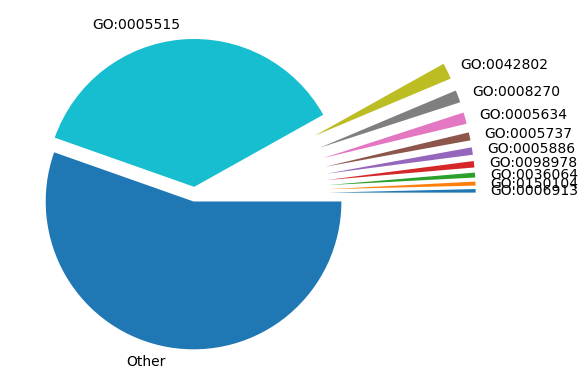

In [26]:
# set up data source for sum_total_count pie chart (want ratio of top 10 to total, with other = remaining)

t10_count_vals = t10_count['count'].to_list()
t10_count_labels = t10_count['GO_ID'].to_list()

# add other category in pie chart 
other_t10_count = model_org_df['count'].sum() - t10_sum_tot_count['count'].sum()
t10_count_vals.append(other_t10_count)
t10_count_labels.append('Other')

# create a pie plot 
plt_explode = [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.05, 0.05]
plt.pie(t10_count_vals, labels=t10_count_labels, explode = plt_explode)
plt.show()

In [27]:
# -- PART 6: How much NIH money is awarded to different institutions? Is there a bias?

# institution = ORG_NAME

In [28]:
# -- PART 7: How much NIH money is awarded to different states? Is there a bias?

# institution = ORG_STATE

In [29]:
# -- PART 8: Has there been a change in amounts of funding awarded over time?

# year = 'FY' ('PROJECT_START', 'PROJECT_END')

